# Full circuit for 1+1d SU(2) Trotter simulation using the LSH formulation with $L=4$, $\Lambda=2$

Using two qubits to represent the bosonic dof at r=2.

Considering first-order Trotter for the moment.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.99'
import sys
sys.path.append('/home/iiyama/src/lsh-qudit')
import numpy as np
import scipy
import jax
import jax.numpy as jnp
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.transpiler import PassManager, StagedPassManager, generate_preset_pass_manager
from qiskit.quantum_info import Operator
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeKawasaki
import lsh_qudit.set_rccx_inverse
from lsh_qudit.constants import sigmaminus, sigmaplus, pauliz
from lsh_qudit.validator_jax import validate_circuit
from lsh_qudit.utils import QubitPlacement, sort_qubits, draw_circuit, clean_array, op_matrix
from lsh_qudit.hamiltonian import (BOSON_TRUNC, physical_states,
                                   mass_term_site, electric_12_term_site, electric_3f_term_site,
                                   electric_3b_term_site, hopping_term_site)
from lsh_qudit.matrices import (mass_hamiltonian, electric_12_hamiltonian, electric_3b_hamiltonian,
                                electric_3f_hamiltonian, hopping_site_hamiltonian,
                                hopping_hamiltonian)
from lsh_qudit.trotter import trotter_step_circuit, trotter_step_unitary
from lsh_qudit.precompiler import lsh_qudit_precompiler
from lsh_qudit.postcompiler import LSHPostcompiler
from lsh_qudit.layout import layout_heavy_hex, layout_candidates
from lsh_qudit.transpiler import transpile_lsh_circuit

jax.config.update('jax_enable_x64', True)

## Model parameters

Using `qiskit` to create the circuits

In [2]:
from qiskit.circuit import Parameter

num_sites = 4
mass_mu = Parameter('$\mu$')
interaction_x = Parameter('x')
time_step = Parameter('$\Delta$t')
# Random not-so-small numbers for numerical validation
dt = 0.73
mu = 0.37
x = 0.87

## $H_M$

$$
\begin{align*}
H_{M}(r) &= H_{M}^{(1)}(r) + H_{M}^{(2)}(r)\,, \\
H_{M}^{(1)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{i(r)}\,,\\
H_{M}^{(2)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{o(r)}\,
\end{align*}
$$

### Circuit

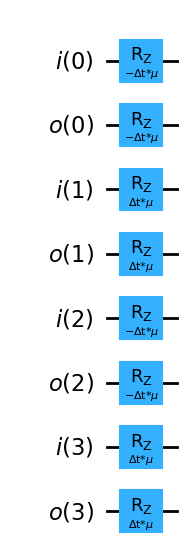

In [3]:
from lsh_qudit.utils import QubitPlacement, draw_circuit
from qiskit import QuantumCircuit
from lsh_qudit.hamiltonian import mass_term_site


qp = QubitPlacement(sum(([('i', site), ('o', site)] for site in range(4)), []))
circuit = QuantumCircuit(qp.num_qubits)
for site in range(4):
    circ, init_p, _ = mass_term_site(site, time_step, mass_mu)
    circuit.compose(circ, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(circuit, qp, reorder=False)

### Validation

In [4]:
from lsh_qudit.utils import sort_qubits
from lsh_qudit.matrices import mass_hamiltonian
import jax.numpy as jnp
import jax
jax.config.update('jax_enable_x64', True)
from lsh_qudit.validator_jax import validate_circuit


assigned = sort_qubits(circuit, qp).assign_parameters({mass_mu: mu, time_step: dt})
hdt = mass_hamiltonian(num_sites, mu, npmod=jnp) * dt
validate_circuit(assigned, hdt, diagonal=True)

True

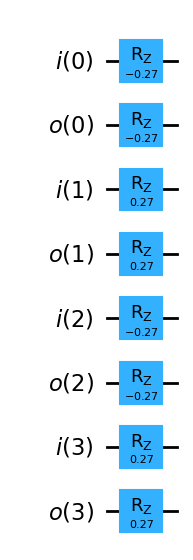

In [5]:
draw_circuit(assigned, qp, reorder=False)

In [6]:
from pytket.extensions.qiskit import qiskit_to_tk
from pytket.circuit.display import render_circuit_jupyter as draw


circ = qiskit_to_tk(assigned)
draw(circ)

## $H_E$

$$
\begin{align}
H_{E}&=H_{E}^{(1)} + H_{E}^{(2)} + H_{E}^{(3)}
\\
H_{E}^{(1)} & = \frac{1}{2}n_{l}(r)\,,
\\
H_{E}^{(2)} & = \frac{1}{4}n_{l}(r)^{2}\,,
\\
H_{E}^{(3)} & = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)\,.
\end{align}
$$

### $H_E^{(1)} + H_E^{(2)} = \frac{1}{2}n_{l}(r) + \frac{1}{4}n_{l}(r)^{2}$ circuit

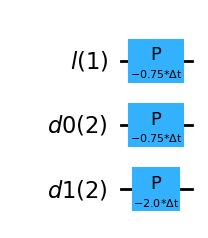

In [7]:
from lsh_qudit.hamiltonian import electric_12_term_site


labels = [('l', 1), ('d0', 2), ('d1', 2)]
qp = QubitPlacement(labels)
circuit = QuantumCircuit(qp.num_qubits)
for site, bc in enumerate([{'max_left_flux': 0}, {'max_left_flux': 1}, {}]):
    circ, init_p, _ = electric_12_term_site(site, time_step, **bc)
    circuit.compose(circ, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(circuit, qp, reorder=False, fold=100)

### $H_E^{(1)} + H_E^{(2)}$ validation

In [8]:
from lsh_qudit.matrices import electric_12_hamiltonian
from lsh_qudit.hamiltonian import physical_states
import numpy as np


assigned = sort_qubits(circuit, qp).assign_parameters({time_step: dt})
hdt = electric_12_hamiltonian(num_sites, max_left_flux=0, max_right_flux=1) * dt
subspace_multi = np.unique(physical_states(max_left_flux=1, num_sites=2, as_multi=True)[:, [5, 2]], axis=0)
subspace = np.concatenate([(subspace_multi[:, 0, None] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 1:]], axis=1)
validate_circuit(assigned, hdt, boson_regs=[(1, 2)], subspace=tuple(subspace.T))

True

In [9]:
circ = qiskit_to_tk(assigned)
draw(circ)

### $H_E^{(3)} = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)$ circuit

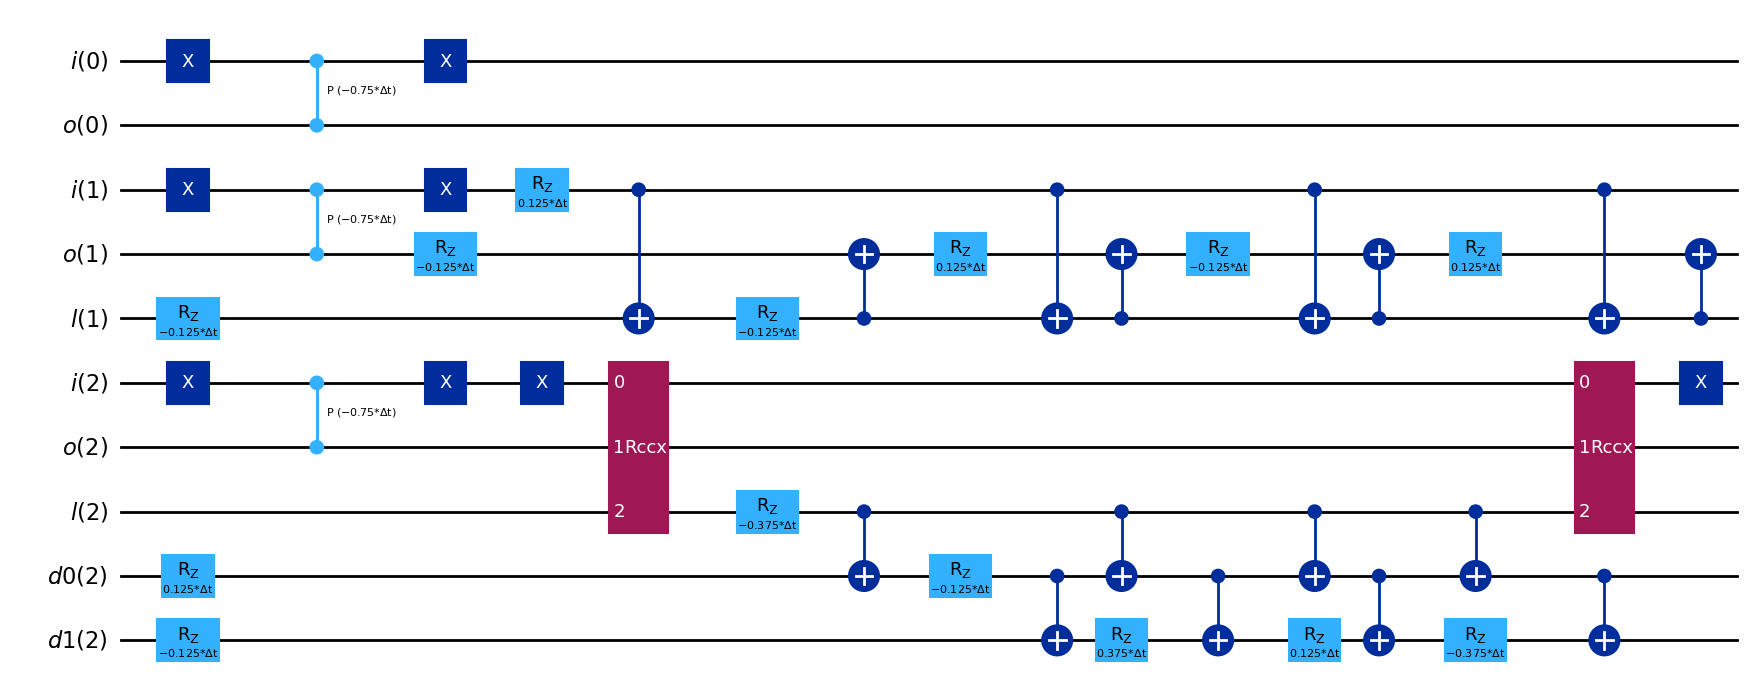

In [10]:
from lsh_qudit.hamiltonian import electric_3f_term_site, electric_3b_term_site

labels = [('o', 0), ('i', 0)]
labels += [('i', 1), ('l', 1), ('o', 1)]
labels += [('l', 2), ('o', 2), ('i', 2), ('d0', 2), ('d1', 2)]
qp = QubitPlacement(labels)
circuit = QuantumCircuit(qp.num_qubits)
for site, bc in enumerate([{'max_left_flux': 0}, {'max_left_flux': 1}, {}]):
    circ, init_p, _ = electric_3f_term_site(site, time_step)
    circuit.compose(circ, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
    circ, init_p, _ = electric_3b_term_site(site, time_step, **bc)
    circuit.compose(circ, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(circuit, qp, fold=100)

### $H_E^{(3)}$ validation

In [11]:
from lsh_qudit.matrices import electric_3f_hamiltonian, electric_3b_hamiltonian
from lsh_qudit.utils import op_matrix


assigned = sort_qubits(circuit, qp).assign_parameters({time_step: dt})
mat_b = electric_3b_hamiltonian(num_sites, max_left_flux=0, max_right_flux=1)
mat_f = electric_3f_hamiltonian(num_sites)
shape = (4, 4, 2, 4, 4)
dim = np.prod(shape)
hmat = np.zeros((dim, dim), dtype=np.complex128)
hmat += op_matrix(mat_b, shape, (4, 3, 2, 1))
hmat += op_matrix(mat_f, shape, (3, 1, 0))
hdt = hmat * dt
subspace_multi = np.unique(physical_states(max_left_flux=0, num_sites=3, as_multi=True)[:, [8, 7, 6, 5, 4, 3, 1, 0]], axis=0)
subspace = np.concatenate([(subspace_multi[:, 0, None] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 1:]], axis=1)
validate_circuit(assigned, hdt, ancillae=(7,), boson_regs=[(8, 9)], subspace=tuple(subspace.T))

True

In [12]:
assigned.qregs

[QuantumRegister(1, 'i(0)'),
 QuantumRegister(1, 'o(0)'),
 QuantumRegister(1, 'i(1)'),
 QuantumRegister(1, 'o(1)'),
 QuantumRegister(1, 'l(1)'),
 QuantumRegister(1, 'i(2)'),
 QuantumRegister(1, 'o(2)'),
 QuantumRegister(1, 'l(2)'),
 QuantumRegister(1, 'd0(2)'),
 QuantumRegister(1, 'd1(2)')]

In [13]:
decompose_rccx = assigned.decompose("rccx")
circ = qiskit_to_tk(decompose_rccx)
draw(circ)

## $H_I$

In [14]:
from lsh_qudit.hamiltonian import hopping_term_config


configs = [hopping_term_config(ttype, site, max_left_flux=lflux, max_right_flux=rflux)
           for ttype, site, lflux, rflux in [(1, 0, 0, -1), (1, 1, 1, -1), (1, 2, -1, 1), (2, 0, 0, -1), (2, 1, 1, -1), (2, 2, -1, 1)]]

config_itr = iter(configs)
for ttype in [1, 2]:
    for site in range(3):
        config = next(config_itr)
        print(ttype, site, config.boson_ops['p'], config.boson_ops['q'])

1 0 ('X', 'id') ('id', 'id')
1 1 ('X', 'id') ('id', 'id')
1 2 ('X', 'id') ('id', 'id')
2 0 ('X', 'id') ('id', 'id')
2 1 ('X', 'id') ('id', 'id')
2 2 ('X', 'id') ('id', 'id')


### $H_I^{(1)}$

The general form of $H_I^{(1)}$ is

$$
\begin{split}
\frac{1}{x} H_I^{(1)}(r) = & H_I^{(1)+}(r) + H_I^{(1)-}(r) \\
= & \ket{0}\bra{1}_{i(r)} Z_{o(r)} \ket{1}\bra{0}_{i(r+1)} \left[ \lambda^+_{l(r)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \right]^{1 - n_o(r)} \left[ \lambda^+_{l(r+1)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \right]^{n_o(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right) \\
& + \ket{1}\bra{0}_{i(r)} Z_{o(r)} \ket{0}\bra{1}_{i(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right)
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \lambda^-_{l(r)} \right]^{1 - n_o(r)}
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \lambda^-_{l(r+1)} \right]^{n_o(r+1)}
\end{split}
$$

Note that the combinations of the allowed $n_i$ and $n_o$ values together with AGL dictates that a
non-annihilated state will have $n_l(r) = n_l(r+1)$.


#### $r=0$ circuit

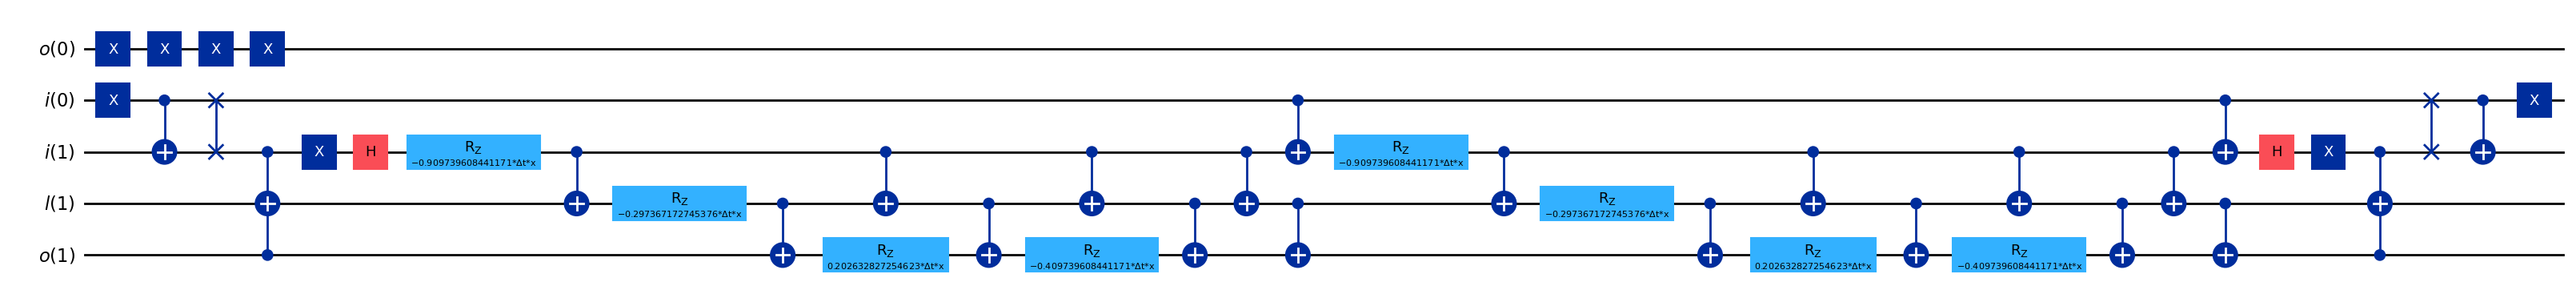

In [15]:
from lsh_qudit.hamiltonian import hopping_term_site

circuit, init_p, _ = hopping_term_site(1, 0, time_step, interaction_x, max_left_flux=0)
draw_circuit(circuit, init_p, reorder=False, fold=60)

#### $r=0$ validation

In [16]:
from lsh_qudit.matrices import hopping_site_hamiltonian


assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('i', 0), ('o', 0), ('i', 1), ('o', 1), ('l', 1)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hdt = hopping_site_hamiltonian(1, x, max_left_flux=0) * dt
subspace = physical_states(max_left_flux=0, num_sites=2, as_multi=True)[:, ::-1]
subspace = np.concatenate([subspace[:, :3], subspace[:, 4:]], axis=1)
validate_circuit(ordered, hdt, subspace=tuple(subspace.T))

True

In [17]:
circ = qiskit_to_tk(ordered)
draw(circ)

#### $r=1$ circuit

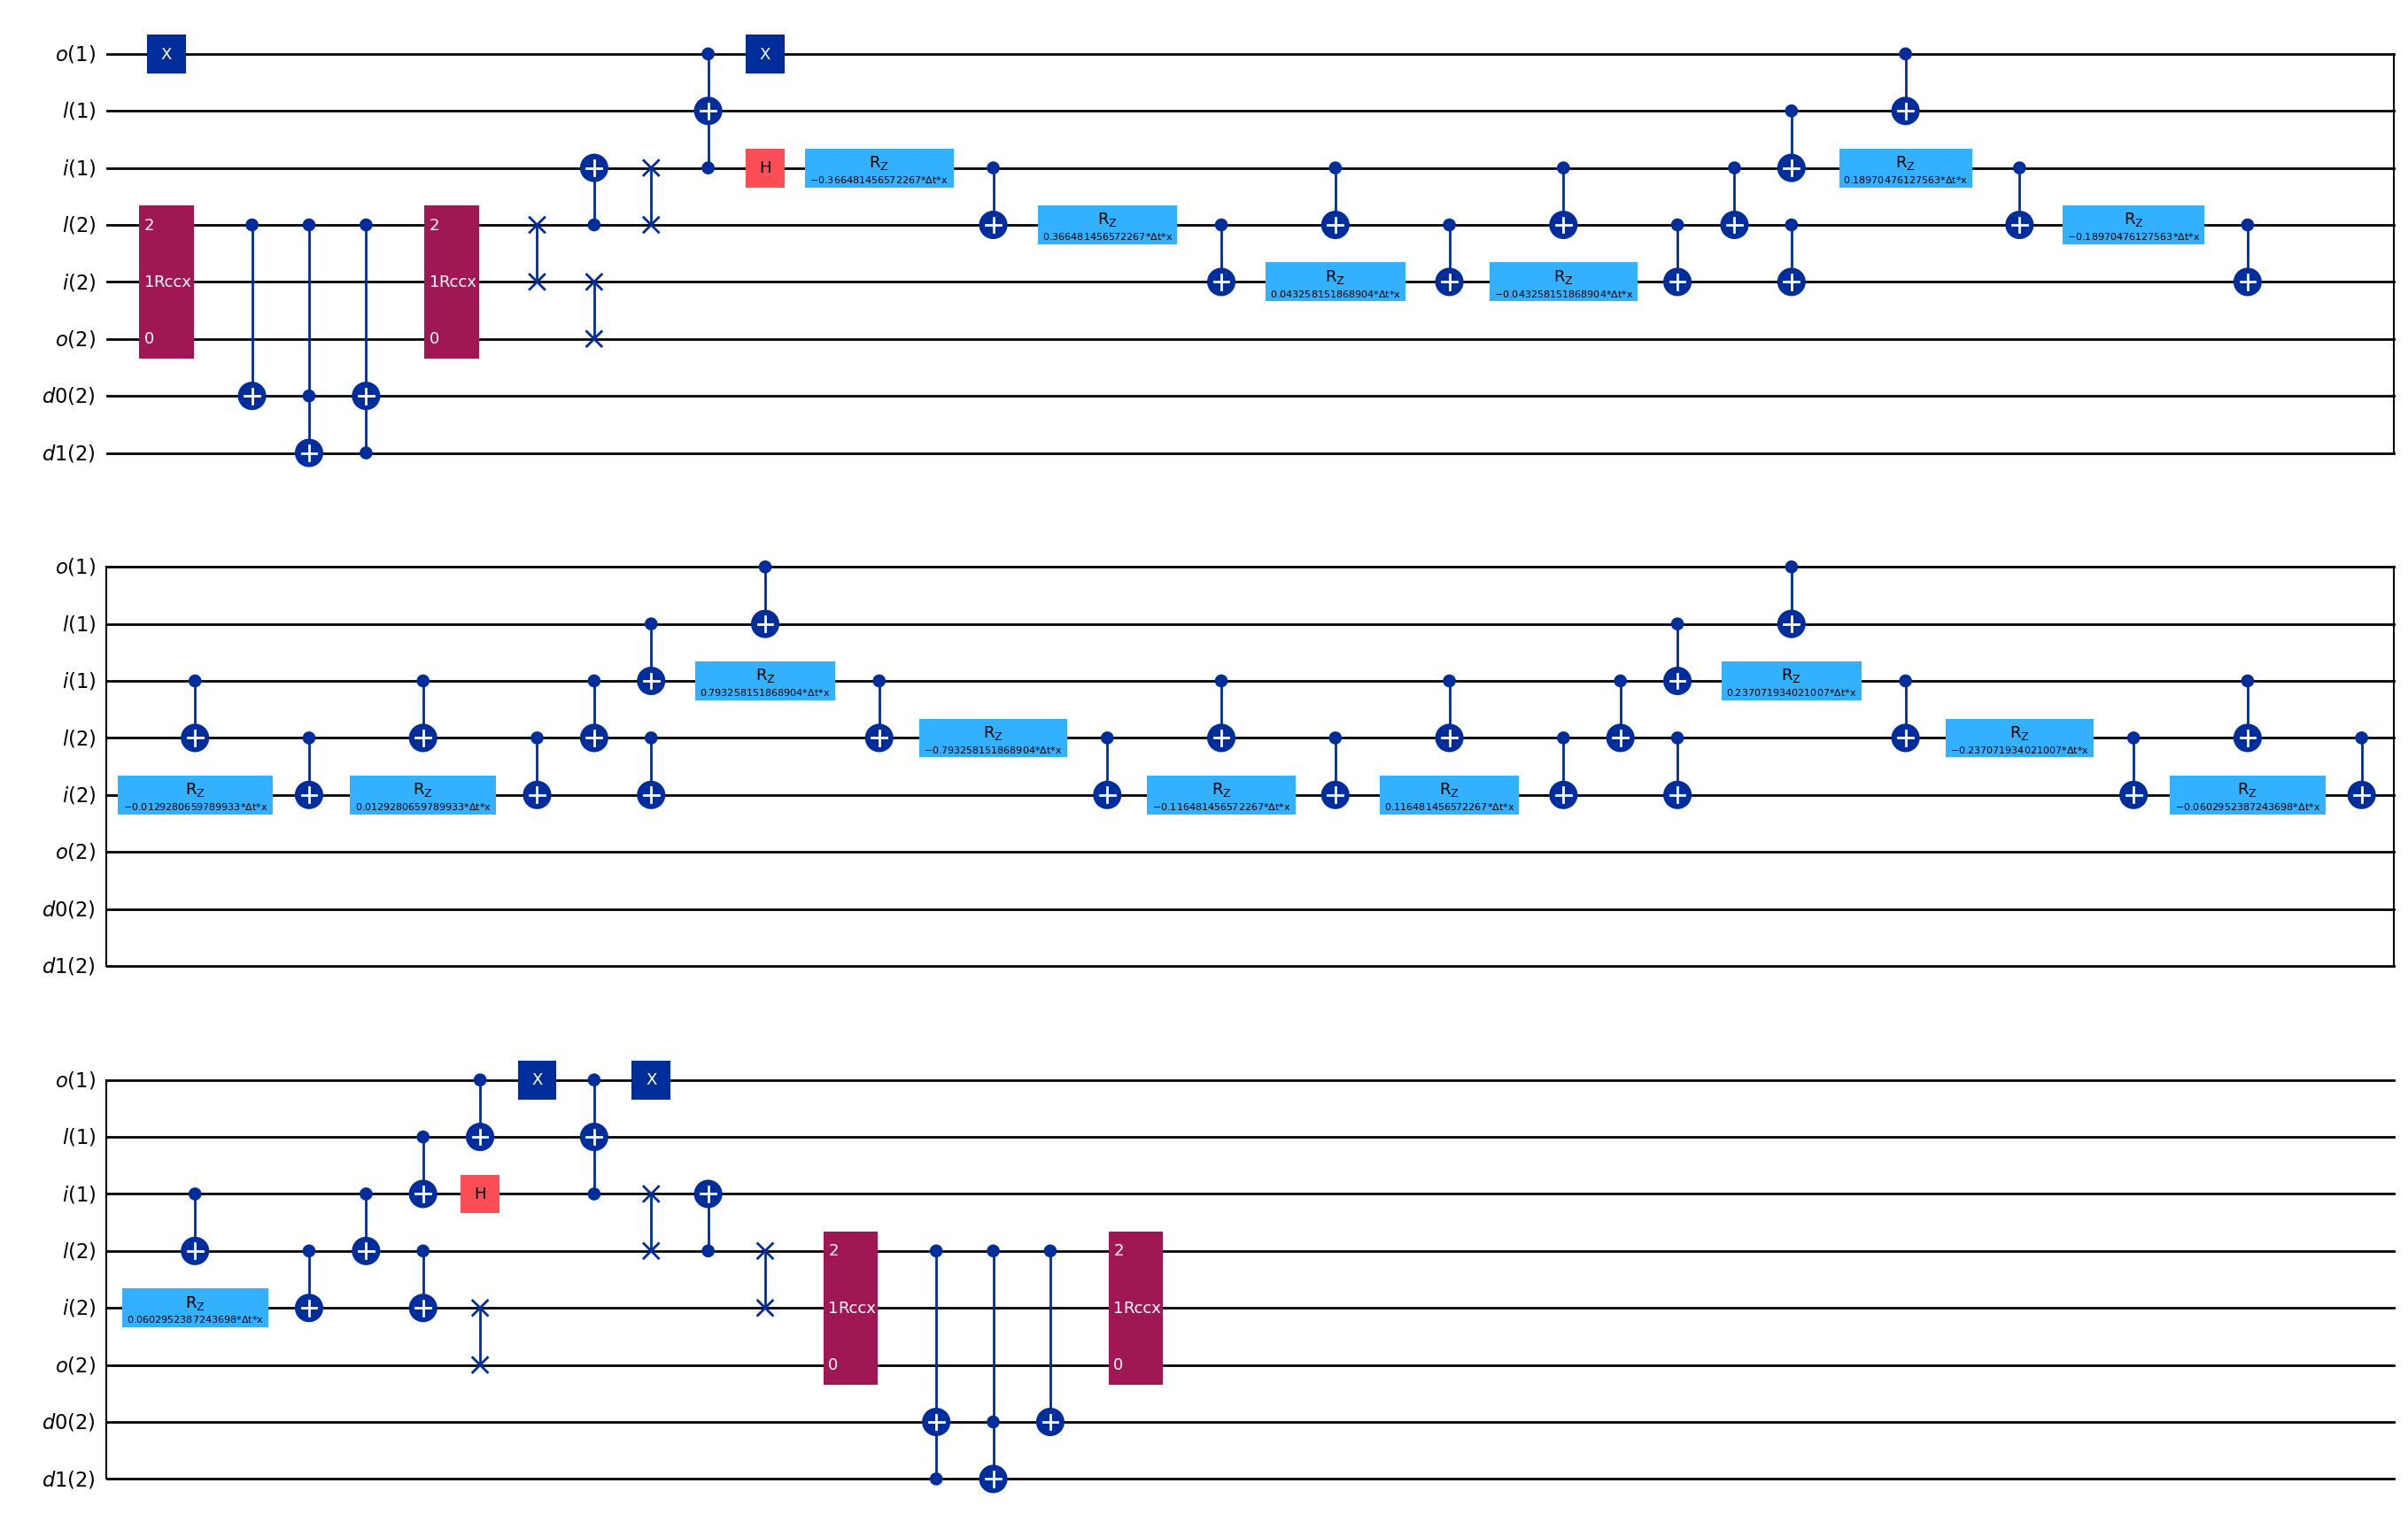

In [18]:
circuit, init_p, _ = hopping_term_site(1, 1, time_step, interaction_x, max_left_flux=1)
draw_circuit(circuit, init_p, reorder=False, fold=40)

#### $r=1$ validation

In [19]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('i', 1), ('o', 1), ('l', 1), ('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hdt = hopping_site_hamiltonian(1, x, max_left_flux=1) * dt
subspace_multi = physical_states(max_left_flux=1, num_sites=2, as_multi=True)[:, ::-1]
subspace = np.concatenate([(subspace_multi[:, :1] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 1:]], axis=1)
validate_circuit(ordered, hdt, ancillae=(5,), boson_regs=[(6, 7)], subspace=tuple(subspace.T))

True

In [20]:
decompose_rccx = ordered.decompose("rccx")
circ = qiskit_to_tk(decompose_rccx)
draw(circ)

In [21]:
from pytket.utils import gate_counts

gate_counts(circ)

Counter({<OpType.CX: 45>: 56,
         <OpType.U1: 39>: 16,
         <OpType.Rz: 36>: 16,
         <OpType.U2: 38>: 8,
         <OpType.CCX: 61>: 6,
         <OpType.SWAP: 62>: 6,
         <OpType.X: 23>: 4,
         <OpType.H: 33>: 2})

#### $r=2$ circuit

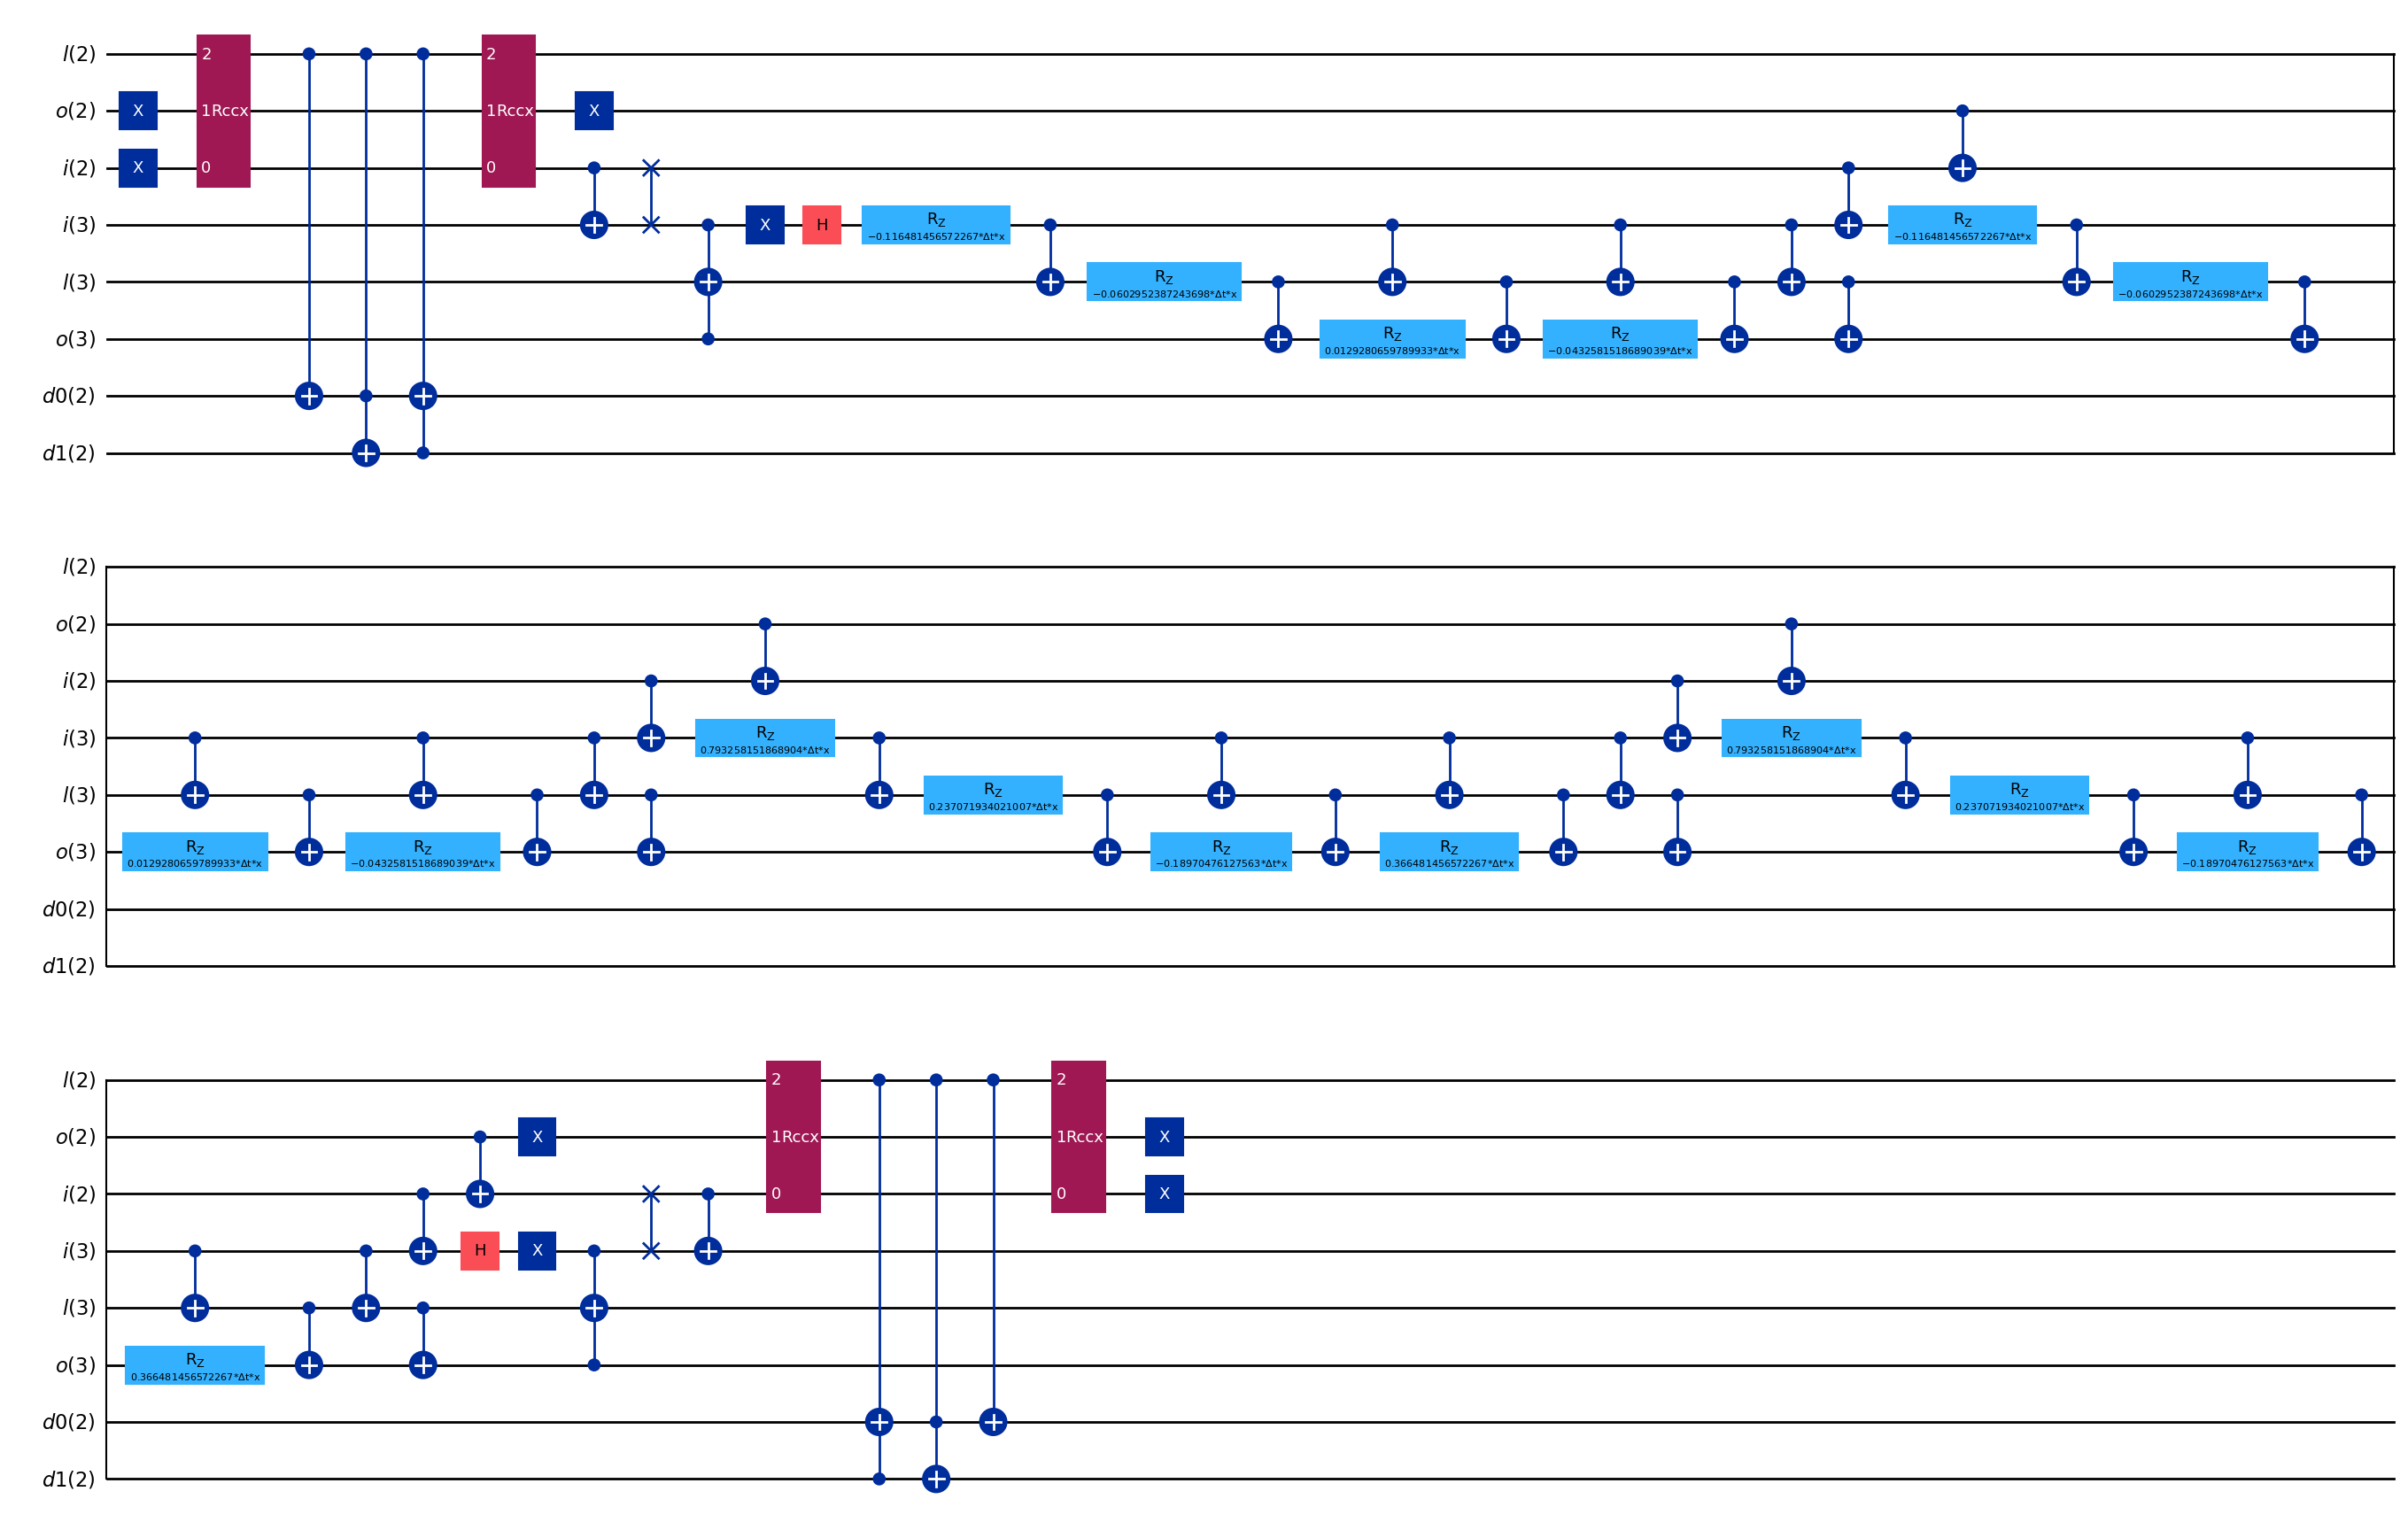

In [22]:
circuit, init_p, _ = hopping_term_site(1, 2, time_step, interaction_x, max_right_flux=1)
draw_circuit(circuit, init_p, reorder=False, fold=40)

#### $r=2$ validation

In [23]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2), ('i', 3), ('o', 3), ('l', 3)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hdt = hopping_site_hamiltonian(1, x, max_right_flux=1) * dt
subspace_multi = physical_states(max_right_flux=1, num_sites=2, as_multi=True)[:, ::-1]
subspace = np.concatenate([subspace_multi[:, :3], (subspace_multi[:, 3:4] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 4:]], axis=1)
validate_circuit(ordered, hdt, ancillae=(2,), boson_regs=[(6, 7)], subspace=tuple(subspace.T))

True

In [24]:
decompose_rccx = ordered.decompose("rccx")
circ = qiskit_to_tk(decompose_rccx)
draw(circ)

### $H_I^{(2)}$

#### $r=0$ circuit

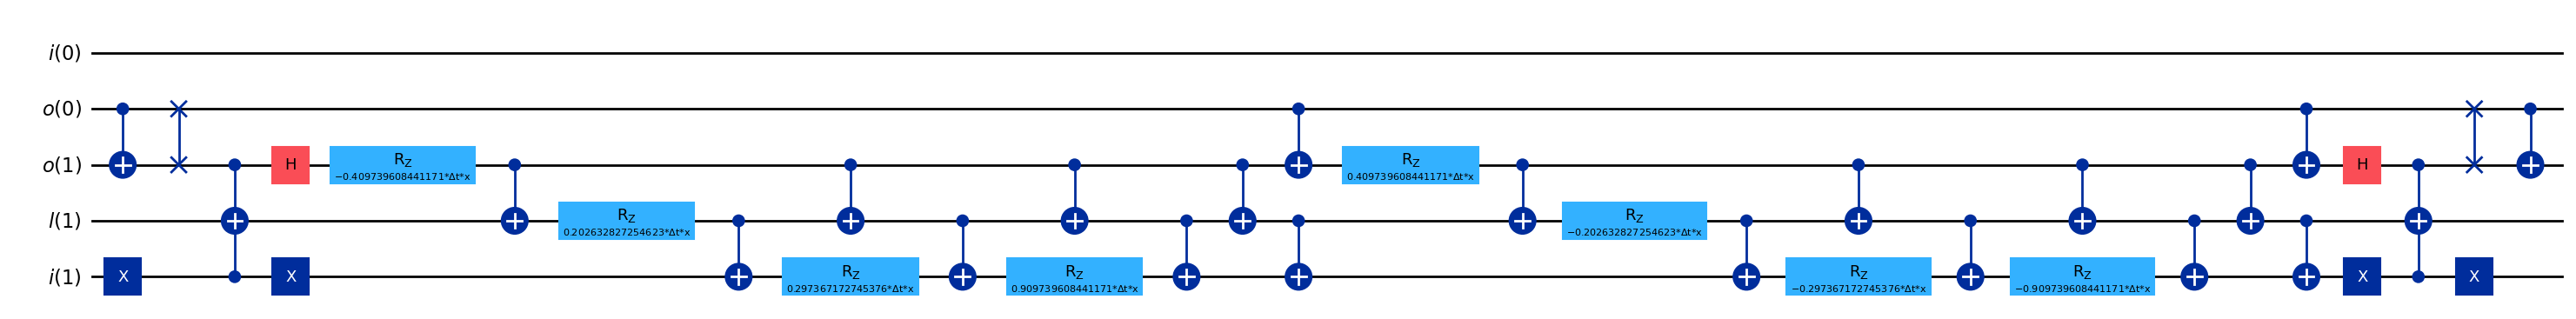

In [25]:
circuit, init_p, _ = hopping_term_site(2, 0, interaction_x, time_step, max_left_flux=0)
draw_circuit(circuit, init_p, reorder=False, fold=100)

#### $r=0$ validation

In [26]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('i', 0), ('o', 0), ('i', 1), ('o', 1), ('l', 1)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hdt = hopping_site_hamiltonian(2, x, max_left_flux=0) * dt
subspace = physical_states(max_left_flux=0, num_sites=2, as_multi=True)[:, ::-1]
subspace = np.concatenate([subspace[:, :3], subspace[:, 4:]], axis=1)
validate_circuit(ordered, hdt, subspace=tuple(subspace.T))

True

#### $r=1$ circuit

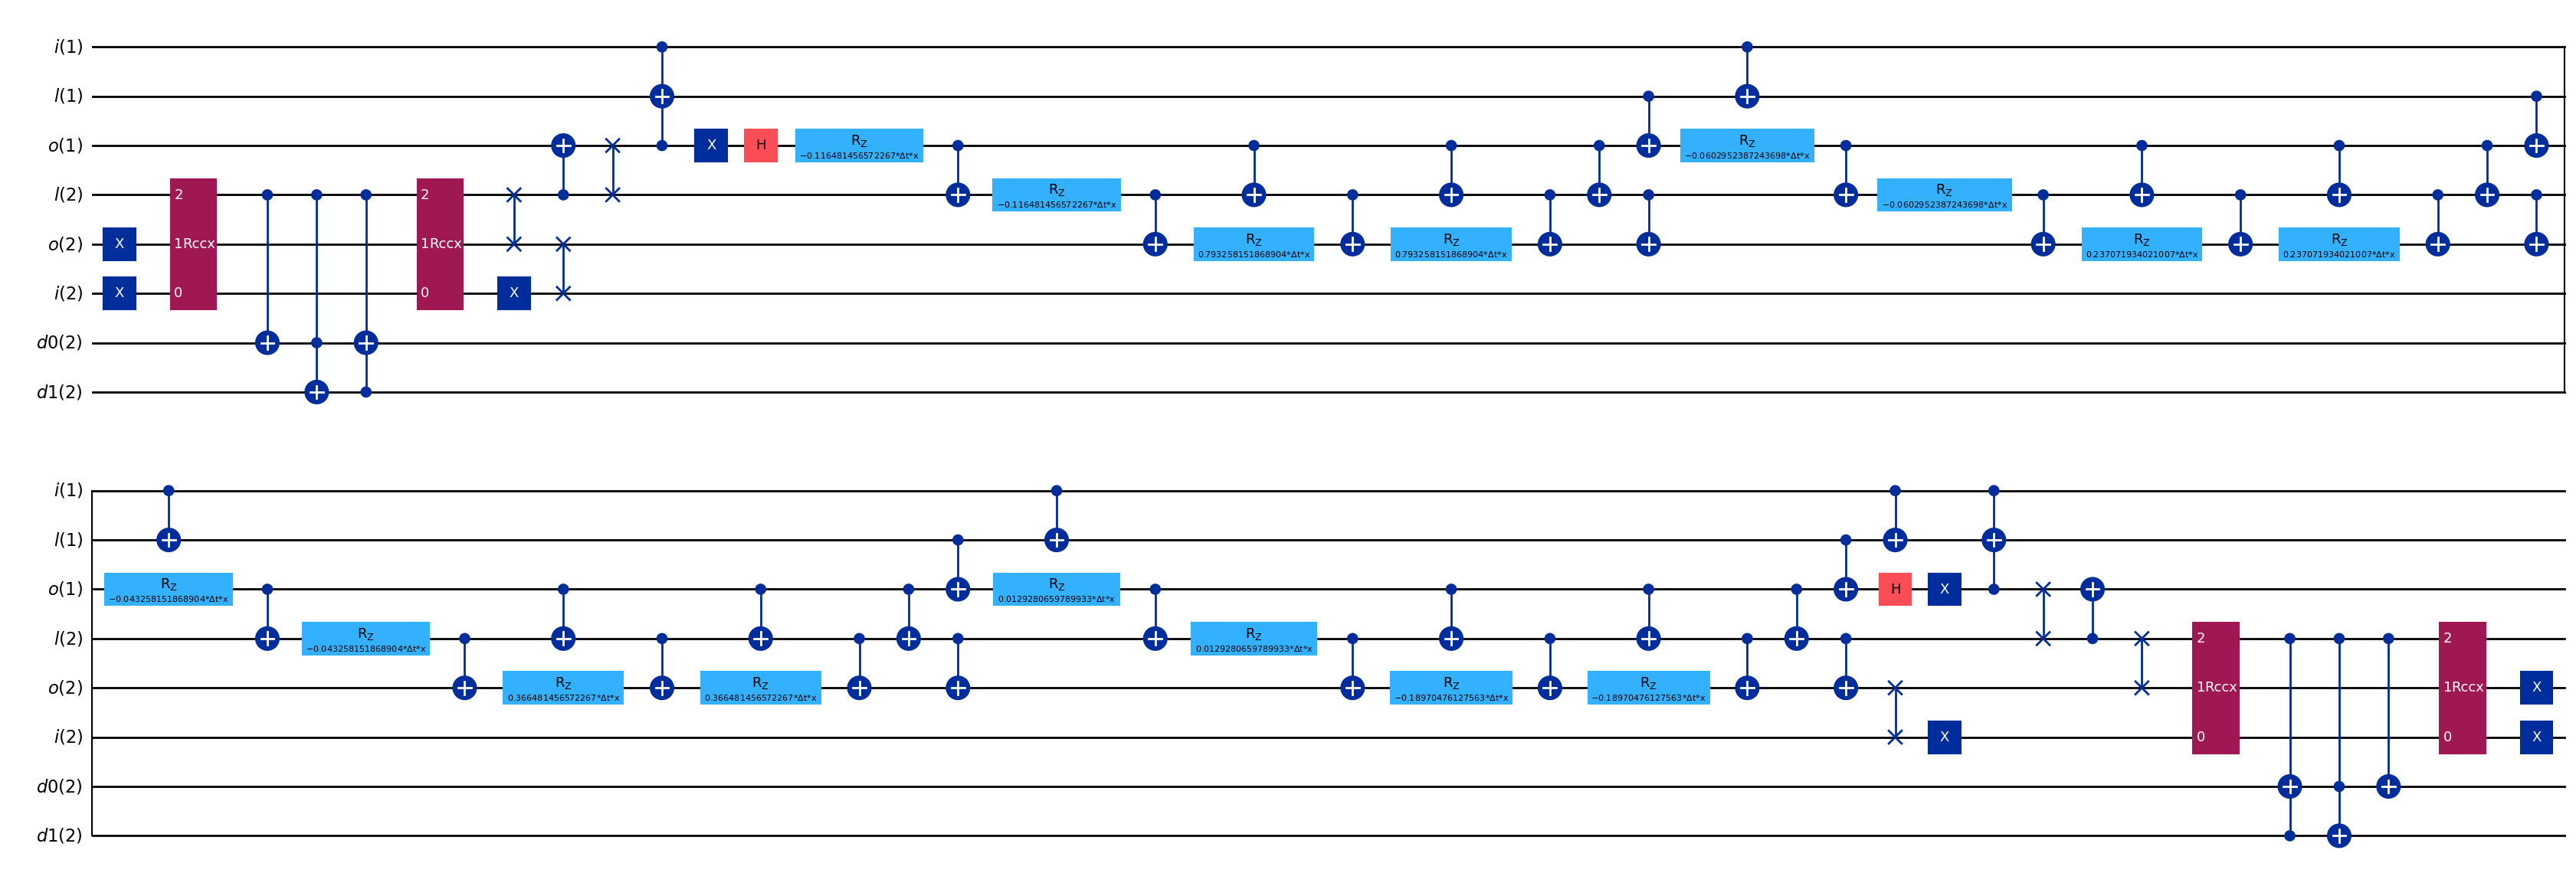

In [27]:
circuit, init_p, _ = hopping_term_site(2, 1, time_step, interaction_x, max_left_flux=1)
draw_circuit(circuit, init_p, reorder=False, fold=50)

#### $r=1$ validation

In [28]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('i', 1), ('o', 1), ('l', 1), ('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hdt = hopping_site_hamiltonian(2, x, max_left_flux=1) * dt
subspace_multi = physical_states(max_left_flux=1, num_sites=2, as_multi=True)[:, ::-1]
subspace = np.concatenate([(subspace_multi[:, :1] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 1:]], axis=1)
validate_circuit(ordered, hdt, ancillae=(5,), boson_regs=[(6, 7)], subspace=tuple(subspace.T))

True

#### $r=2$ circuit

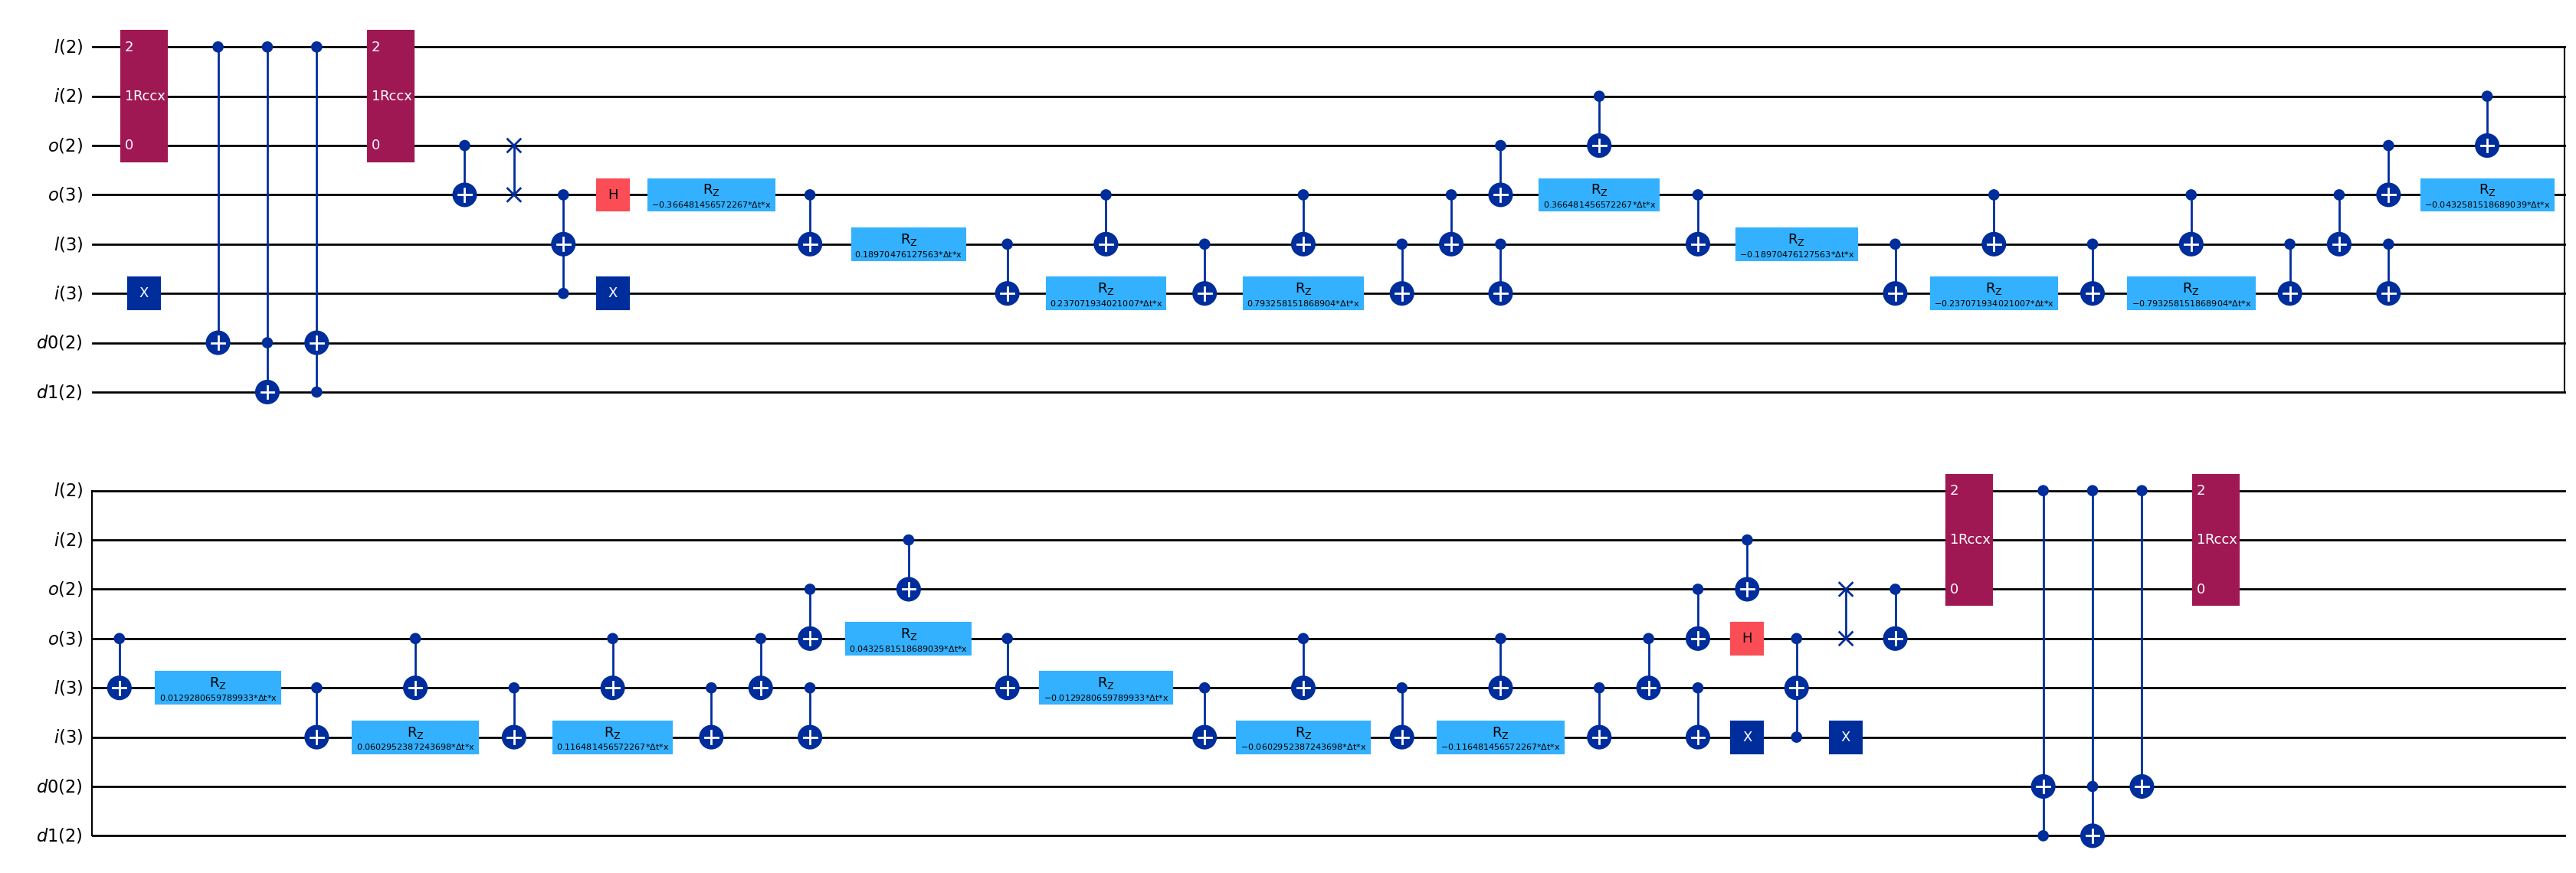

In [29]:
circuit, init_p, _ = hopping_term_site(2, 2, time_step, interaction_x, max_right_flux=1)
draw_circuit(circuit, init_p, reorder=False, fold=50)

#### $r=2$ validation

In [30]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2), ('i', 3), ('o', 3), ('l', 3)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hdt = hopping_site_hamiltonian(2, x, max_right_flux=1) * dt
subspace_multi = physical_states(max_right_flux=1, num_sites=2, as_multi=True)[:, ::-1]
subspace = np.concatenate([subspace_multi[:, :3], (subspace_multi[:, 3:4] >> np.arange(2)[None, ::-1]) % 2, subspace_multi[:, 4:]], axis=1)
validate_circuit(ordered, hdt, ancillae=(2,), boson_regs=[(6, 7)], subspace=tuple(subspace.T))

True

## Full Hamiltonian (first-order Trotter)

### Circuit

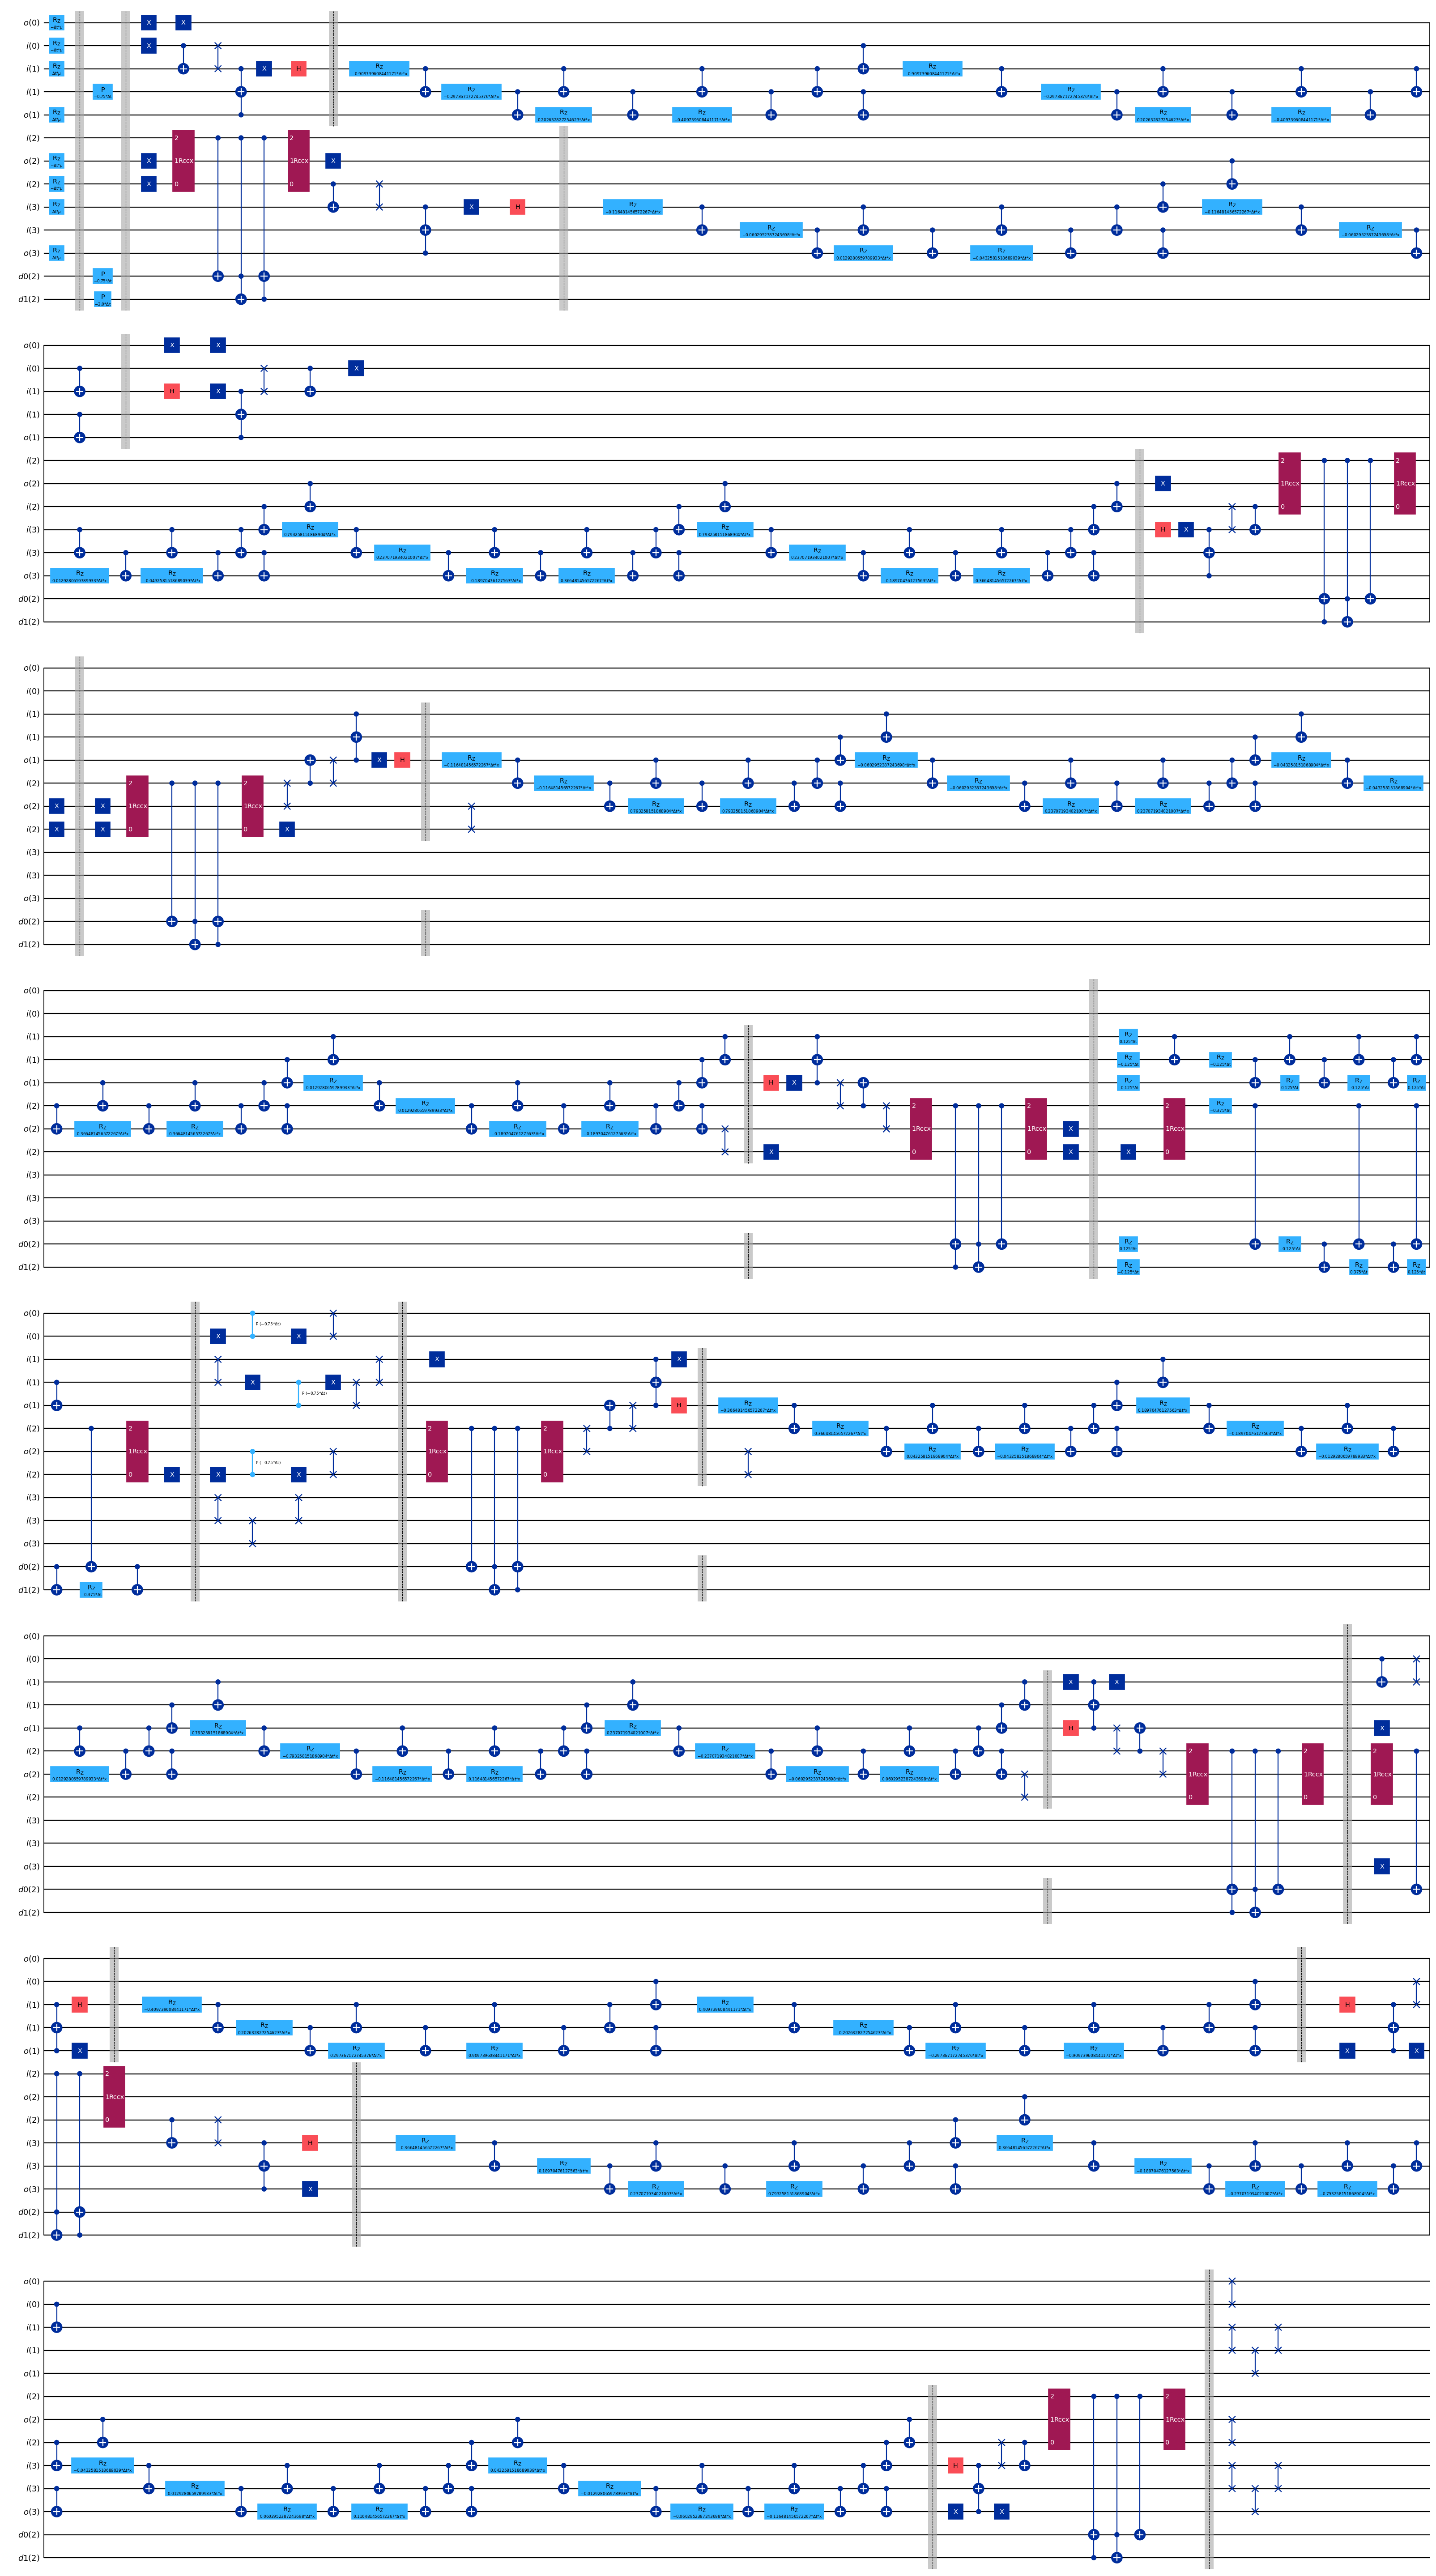

In [31]:
from lsh_qudit.trotter import trotter_step_circuit 

full_qp = QubitPlacement(
    [('o', 0), ('i', 0)]
    + [('i', 1), ('l', 1), ('o', 1)]
    + [('l', 2), ('o', 2), ('i', 2)]
    + [('i', 3), ('l', 3), ('o', 3)]
    + [('d0', 2), ('d1', 2)]
)
full_circuit = trotter_step_circuit(4, time_step, mass_mu, interaction_x, qp=full_qp,
                                    max_left_flux=0, max_right_flux=1, with_barrier=True)[0]
draw_circuit(full_circuit, full_qp, reorder=False, scale=0.8, fold=60)

In [32]:
from lsh_qudit.precompiler import lsh_qudit_precompiler

precompile_pm = lsh_qudit_precompiler()
precompiled = precompile_pm.run(full_circuit)
precompiled.count_ops()

OrderedDict([('cx', 504),
             ('rz', 251),
             ('h', 60),
             ('x', 30),
             ('t', 20),
             ('tdg', 20),
             ('p', 3)])

In [33]:
# draw_circuit(precompiled, full_qp, reorder=False, scale=0.8, fold=60)

### Validation

In [35]:
from lsh_qudit.trotter import trotter_step_unitary

assigned = precompiled.assign_parameters({interaction_x: x, time_step: dt, mass_mu: mu})
# assigned = precompiled.assign_parameters({time_step: dt, mass_mu: mu})
# assigned = precompiled.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement(
    [('i', 0), ('o', 0)]
    + [('i', 1), ('o', 1), ('l', 1)]
    + [('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2)]
    + [('i', 3), ('o', 3), ('l', 3)]
)
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in full_qp.qubit_labels], inplace=True)
ancillae = (7,)
boson_regs = [(8, 9)]

umat = trotter_step_unitary(num_sites, dt, mu, x, max_left_flux=0, max_right_flux=1, npmod=jnp)

subspace_multi = physical_states(max_left_flux=0, max_right_flux=1, num_sites=4, as_multi=True)[:, ::-1]
subspace = np.concatenate(
    [
        subspace_multi[:, :3],
        (subspace_multi[:, 3:4] >> np.array([[1, 0]])) % 2,
        subspace_multi[:, 4:9],
        subspace_multi[:, 10:]
    ],
    axis=1)
validate_circuit(ordered, umat, ancillae=ancillae, boson_regs=boson_regs, exponentiate=False, subspace=tuple(subspace.T))

KeyboardInterrupt: 

### Pytket

In [36]:
circ = qiskit_to_tk(ordered)
draw(circ)

In [37]:
circ.depth()

418

In [38]:
circ.depth_2q()

304

In [39]:
gate_counts(circ)

Counter({<OpType.CX: 45>: 504,
         <OpType.Rz: 36>: 251,
         <OpType.H: 33>: 60,
         <OpType.X: 23>: 30,
         <OpType.T: 27>: 20,
         <OpType.Tdg: 28>: 20,
         <OpType.U1: 39>: 3})

In [40]:
from pytket.passes import SynthesiseTK, SynthesiseTket

circuit_tk = circ.copy()
SynthesiseTK().apply(circuit_tk)
gate_counts(circuit_tk)

Counter({<OpType.TK1: 43>: 782, <OpType.TK2: 44>: 504})

In [41]:
circuit_tket = circ.copy()
SynthesiseTket().apply(circuit_tket)
gate_counts(circuit_tket)

Counter({<OpType.CX: 45>: 502, <OpType.TK1: 43>: 301})

### Pytket-Quantinuum

Local compilation with `pip install pytket-quantinuum[pecos]`

In [42]:
from pytket.extensions.quantinuum import QuantinuumAPIOffline, QuantinuumBackend

backend = QuantinuumBackend("H1-1LE", api_handler=QuantinuumAPIOffline())


In [43]:
compiled_circuit = backend.get_compiled_circuit(circuit_tket, optimisation_level=3)

In [44]:
gate_counts(compiled_circuit)

Counter({<OpType.PhasedX: 71>: 331,
         <OpType.ZZPhase: 76>: 239,
         <OpType.Rz: 36>: 13})

In [46]:
compiled_circuit = backend.get_compiled_circuit(circ, optimisation_level=3)

In [47]:
gate_counts(compiled_circuit)

Counter({<OpType.PhasedX: 71>: 343,
         <OpType.ZZPhase: 76>: 234,
         <OpType.Rz: 36>: 13})

In [48]:
compiled_circuit = backend.get_compiled_circuit(circ, optimisation_level=2)

In [49]:
gate_counts(compiled_circuit)

Counter({<OpType.PhasedX: 71>: 621,
         <OpType.ZZPhase: 76>: 415,
         <OpType.Rz: 36>: 13})

### Nexus

In [ ]:
import qnexus as qnx

config = qnx.QuantinuumConfig(device_name='H1-1LE')

In [86]:
project = qnx.projects.get_or_create(name="LSH-Qubit-4")
qnx.context.set_active_project(project)

In [118]:
circ_ref = qnx.circuits.upload(circuit=circuit_tket, name="SynthesisTket-1-Single-Trotter")

In [136]:
compile_ref = qnx.start_compile_job(circuits=[circ_ref], backend_config=config, optimisation_level=3, name="Single-Trotter-level-3-tket")

In [137]:
qnx.jobs.wait_for(compile_ref)

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 4, 2, 6, 2, 49, 768744, tzinfo=datetime.timezone.utc), queued_time=datetime.datetime(2025, 4, 2, 6, 2, 42, 461510, tzinfo=datetime.timezone.utc), submitted_time=datetime.datetime(2025, 4, 2, 6, 2, 40, 967776, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 4, 2, 6, 2, 46, 880258, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)

In [138]:
results = qnx.jobs.results(compile_ref)

In [139]:
compiled_circ_ref = results[0].get_output()

In [140]:
compiled_circ = compiled_circ_ref.download_circuit()

In [141]:
# draw(compiled_circ)

In [142]:
gate_counts(compiled_circ)

Counter({<OpType.PhasedX: 71>: 331,
         <OpType.ZZPhase: 76>: 239,
         <OpType.Rz: 36>: 13})

In [143]:
compiled_circ.depth()

255

In [144]:
qnx.jobs.get_all(name_like="Single-Trotter").df()

name description                          created  \
0       Single-Trotter-level-2             2025-04-02 05:38:36.046567+00:00   
1       Single-Trotter-level-3             2025-04-02 05:42:42.013191+00:00   
2       Single-Trotter-level-1             2025-04-02 05:56:17.882230+00:00   
3  Single-Trotter-level-1-tket             2025-04-02 06:00:30.730488+00:00   
4  Single-Trotter-level-2-tket             2025-04-02 06:01:40.121049+00:00   
5  Single-Trotter-level-3-tket             2025-04-02 06:02:40.963948+00:00   

                          modified         job_type           last_status  \
0 2025-04-02 05:38:49.571024+00:00  JobType.COMPILE  StatusEnum.COMPLETED   
1 2025-04-02 05:42:46.578180+00:00  JobType.COMPILE  StatusEnum.COMPLETED   
2 2025-04-02 05:56:27.381660+00:00  JobType.COMPILE  StatusEnum.COMPLETED   
3 2025-04-02 06:00:37.149777+00:00  JobType.COMPILE  StatusEnum.COMPLETED   
4 2025-04-02 06:01:49.497357+00:00  JobType.COMPILE  StatusEnum.COMPLETED   
5 2025-04-02 06:02:49.768744+00:00  JobType.COMPILE  StatusEnum.COMPLETED   

       project                                    id  
0  LSH-Qubit-4  2331f79e-b6b2-48f0-afd8-ef6e506074e7  
1  LSH-Qubit-4  ff696313-0a04-4daa-8daf-e0dc198e1b25  
2  LSH-Qubit-4  9c9306e1-22e9-49fd-8a91-070fdf8ce826  
3  LSH-Qubit-4  6103ea20-0ce8-4101-831e-79e3125dc4f6  
4  LSH-Qubit-4  539a8636-c7d5-4b01-8338-0813a386242d  
5  LSH-Qubit-4  ec7bea35-6135-43c7-a5a8-e6abbe877ae5

## Full Hamiltonian (second-order Trotter)

### Circuit (op count)

In [27]:
full_qp = QubitPlacement(
    [('o', 0), ('i', 0)]
    + [('i', 1), ('l', 1), ('o', 1)]
    + [('l', 2), ('o', 2), ('i', 2)]
    + [('i', 3), ('l', 3), ('o', 3)]
    + [('d0', 2), ('d1', 2)]
)
full_circuit = trotter_step_circuit(4, time_step, mass_mu, interaction_x, qp=full_qp,
                                    max_left_flux=0, max_right_flux=1, with_barrier=True,
                                    second_order=True)[0]
precompile_pm = lsh_qudit_precompiler()
precompiled = precompile_pm.run(full_circuit)
precompiled.count_ops()

OrderedDict([('cx', 810),
             ('rz', 422),
             ('h', 94),
             ('x', 50),
             ('t', 32),
             ('tdg', 32),
             ('p', 6)])

### Validation

In [28]:
assigned = precompiled.assign_parameters({interaction_x: x, time_step: dt, mass_mu: mu})
# assigned = precompiled.assign_parameters({time_step: dt, mass_mu: mu})
# assigned = precompiled.assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement(
    [('i', 0), ('o', 0)]
    + [('i', 1), ('o', 1), ('l', 1)]
    + [('i', 2), ('o', 2), ('l', 2), ('d0', 2), ('d1', 2)]
    + [('i', 3), ('o', 3), ('l', 3)]
)
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in full_qp.qubit_labels], inplace=True)

umat = trotter_step_unitary(num_sites, dt, mu, x, max_left_flux=0, max_right_flux=1, second_order=True, npmod=jnp)

subspace_multi = physical_states(max_left_flux=0, max_right_flux=1, num_sites=4, as_multi=True)[:, ::-1]
subspace = np.concatenate(
    [
        subspace_multi[:, :3],
        (subspace_multi[:, 3:4] >> np.array([[1, 0]])) % 2,
        subspace_multi[:, 4:9],
        subspace_multi[:, 10:]
    ],
    axis=1)
validate_circuit(ordered, umat, ancillae=ancillae, boson_regs=boson_regs, exponentiate=False, subspace=tuple(subspace.T))

True

## Transpilation

In [30]:
backend = FakeTorino()

full_qp = QubitPlacement(
    [('o', 0), ('i', 0)]
    + [('i', 1), ('l', 1), ('o', 1)]
    + [('l', 2), ('o', 2), ('i', 2)]
    + [('i', 3), ('l', 3), ('o', 3)]
    + [('d0', 2), ('d1', 2)]
)
full_circuit = trotter_step_circuit(4, time_step, mass_mu, interaction_x, qp=full_qp,
                                    max_left_flux=0, max_right_flux=1, with_barrier=True)[0]
transpiled = transpile_lsh_circuit(full_circuit, backend, qp=full_qp)
transpiled.count_ops()

OrderedDict([('rz', 1056), ('sx', 882), ('cz', 498), ('x', 9), ('z', 2)])

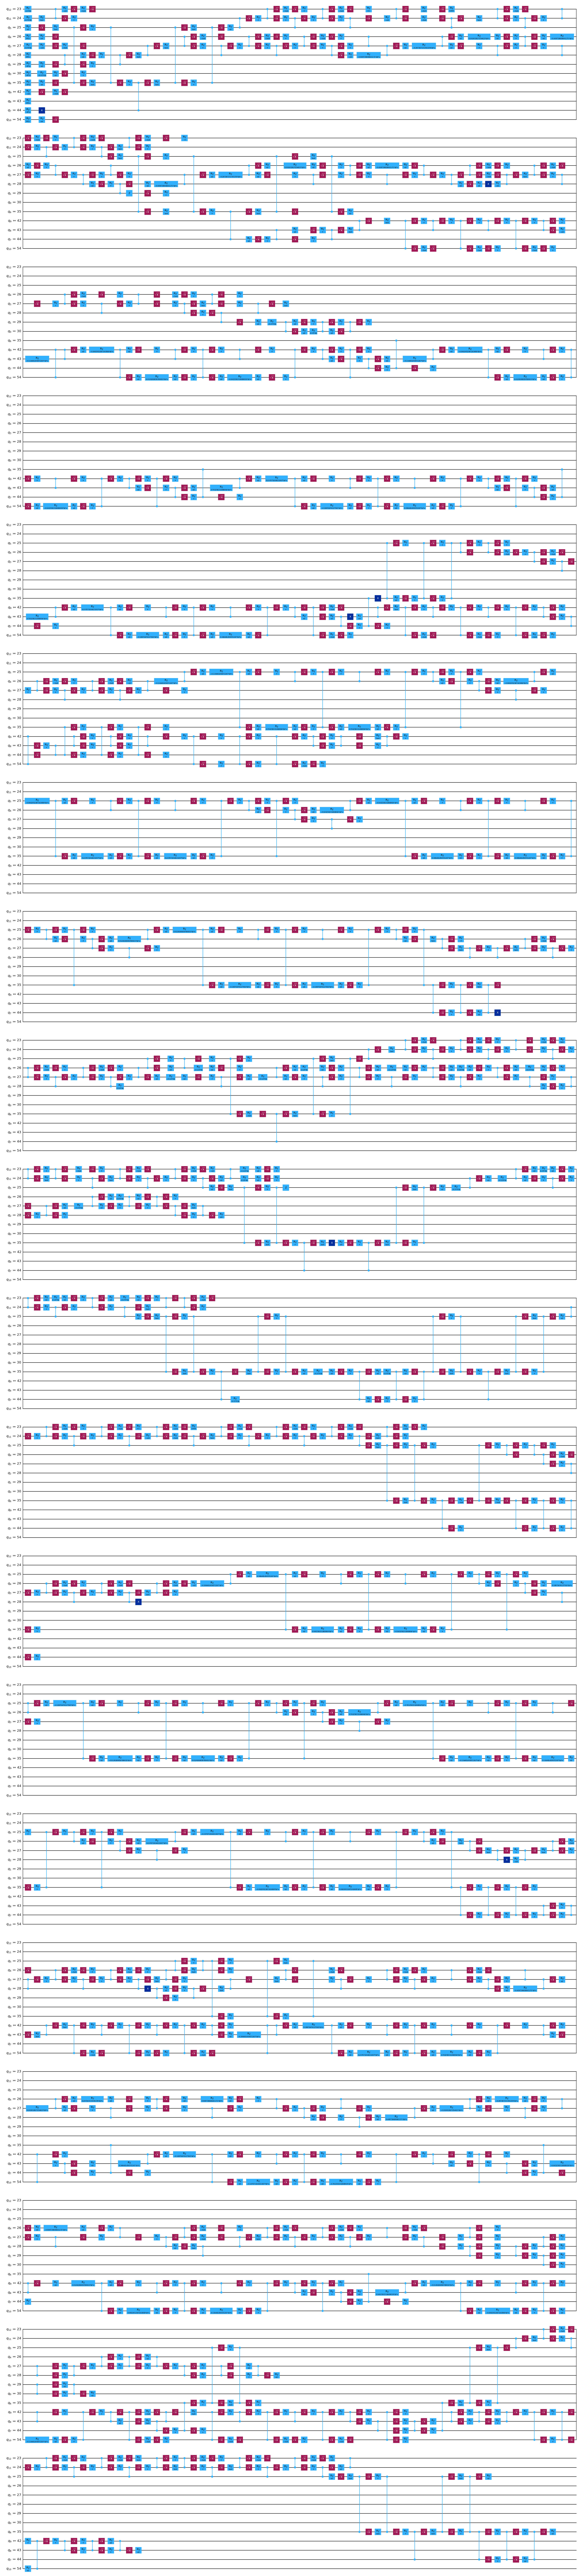

In [31]:
transpiled.draw('mpl', idle_wires=False, scale=0.8, fold=60)

### Validating the postcompiler

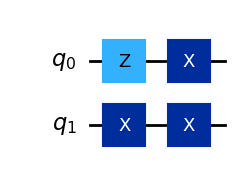

In [32]:
circuit = QuantumCircuit(2)
circuit.cz(0, 1)
circuit.x(1)
circuit.cz(0, 1)
circuit.cx(0, 1)
circuit.x(0)
circuit.cx(0, 1)

postcompile_pm = PassManager([LSHPostcompiler()])
postcompiled = postcompile_pm.run(circuit)
postcompiled.draw('mpl')

In [33]:
d = Operator(circuit.compose(postcompiled.inverse())).data
np.allclose(d * d[0, 0].conjugate(), np.eye(4))

True